In [511]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import integrate

In [512]:
data = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v3/epidemiology.csv")

In [513]:
print(data)

                date location_key  new_confirmed  new_deceased  new_recovered  \
0         2020-01-01           AD            0.0           0.0            NaN   
1         2020-01-02           AD            0.0           0.0            NaN   
2         2020-01-03           AD            0.0           0.0            NaN   
3         2020-01-04           AD            0.0           0.0            NaN   
4         2020-01-05           AD            0.0           0.0            NaN   
...              ...          ...            ...           ...            ...   
11864510  2022-05-25           ZW          291.0           2.0            NaN   
11864511  2022-05-26           ZW          313.0           2.0            NaN   
11864512  2022-05-27           ZW         -867.0           0.0            NaN   
11864513  2022-05-28           ZW            0.0           0.0            NaN   
11864514  2022-05-29           ZW            0.0           0.0            NaN   

          new_tested  cumul

In [514]:
data = data.fillna(0)

In [515]:
data.loc[:, 'date'] = pd.to_datetime(data.loc[:, 'date'], format="%Y.%m.%d")

In [516]:
df = data[data['location_key'] == 'IT_62_RM'].copy().reset_index(drop=True)

In [517]:
df_tmp = df[['date', 'new_confirmed']]
df_tmp['test'] = 0

C:\Users\User\AppData\Local\Temp/ipykernel_18016/2321468386.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['test'] = 0


In [518]:
for i in range(13, df_tmp.shape[0]):
    sum = 0
    for j in range(14):
        sum += df_tmp.loc[i-j, 'new_confirmed']
    df_tmp.loc[i, 'test'] = sum
#     print(str(i) + ' ' + str(sum))

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


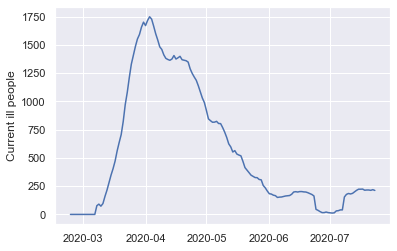

In [519]:
plt.plot(df_tmp.loc[:150, 'date'], df_tmp.loc[:150, 'test'])
plt.ylabel('Current ill people')
plt.show()

In [520]:
#for covid
N = 2_873_000
I0 = 2
S0 = N - I0
E0 = 0
R0 = 0

R_0 = 2.5
gamma = 0.0714
my = 0.0000335
beta = R_0 * (gamma + my)
sigma = 0.192
theta = 0.4

In [539]:
#for H1N1
N = 1_000_000
I0 = 1_000_0 
E0 = 0
S0 = N - I0 - E0
R0 = 0

gamma = 0.222
my = 0.0000386
beta = 0.411
sigma = 0.5

In [540]:
def sir_model(t, y, N, beta, gamma, my):
    S, I, R = y
    dS_dt = - beta * I * S / N
    dI_dt = beta * I * S / N - gamma * I
    dR_dt = gamma * I
    return dS_dt, dI_dt, dR_dt

In [541]:
def sir_model_demography(t, y, N, beta, gamma, my):
    S, I, R = y
    dS_dt = my - beta * I * S / N - my * S
    dI_dt = beta * I * S / N - gamma * I - my * I
    dR_dt = gamma * I - my * R
    return dS_dt, dI_dt, dR_dt

In [542]:
def seir_model(t, y, N, beta, gamma, my, sigma):
    S, E, I, R = y
    dS_dt = my - beta * I * S / N - my * S
    dE_dt = beta * I * S / N - sigma * E - my * E
    dI_dt = sigma * E - my * I - gamma * I
    dR_dt = gamma * I - my * R
    return dS_dt, dE_dt, dI_dt, dR_dt

In [543]:
T = 100
t = np.linspace(0, T, 300)

In [544]:
#SIR and SIR with demography
sol = integrate.solve_ivp(sir_model, [0, T], [S0, I0, R0], dense_output=True, args=[N, beta, gamma, my], method='DOP853')
y = sol.sol(t)

In [545]:
# #SIR and SIR with demography
# S, I, R = y[0, :], y[1, :], y[2, :]

# sns.set()

# sns.lineplot(x=t, y=S, color='#F57C32', label='S') # графік для підвержених
# sns.lineplot(x=t, y=I, color='#07F5AB', label='I') # графік для інфікованих
# sns.lineplot(x=t, y=R, color='#8548A8', label='R') # графік для одужавших
# sns.lineplot(x=t[I.argmax()], y=[0, N], color='black') # лінія для максимальної кількості захворівших

# plt.title('Model without demography')
# plt.xlabel('T, days')
# plt.ylabel('Population')

# plt.legend()

# plt.show()

In [546]:
#SEIR
sol = integrate.solve_ivp(seir_model, [0, T], [S0, E0, I0, R0], dense_output=True, args=[N, beta, gamma, my, sigma], method='DOP853')
y = sol.sol(t)

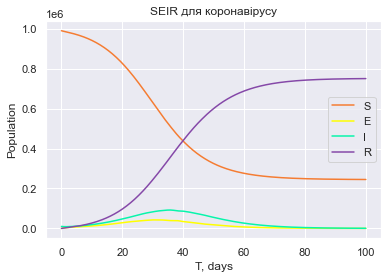

In [547]:
#seir
S, E, I, R = y[0, :], y[1, :], y[2, :], y[3, :]

sns.set()

sns.lineplot(x=t, y=S, color='#F57C32', label='S') # графік для підвержених
sns.lineplot(x=t, y=E, color='yellow', label='E') # графік для інфікованих у інкубаційний період
sns.lineplot(x=t, y=I, color='#07F5AB', label='I') # графік для інфікованих
sns.lineplot(x=t, y=R, color='#8548A8', label='R') # графік для одужавших
# sns.lineplot(x=t[I.argmax()], y=[0, N], color='black') # лінія для максимальної кількості захворівших

plt.title('SEIR для коронавірусу')
plt.xlabel('T, days')
plt.ylabel('Population')

plt.legend()

plt.show()